In [3]:
import cv2
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from ppo_mario.imitation.dataset import MarioDataset
from stable_baselines3 import PPO

# load the model
model = PPO.load("archive/2024-07-31_17-26/model.zip", device="cpu")
features_extractor = model.policy.vf_features_extractor
# and the dataset with its loader
dataset = MarioDataset("assets/playthrough/samples", device="cpu")
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Run the model with some data

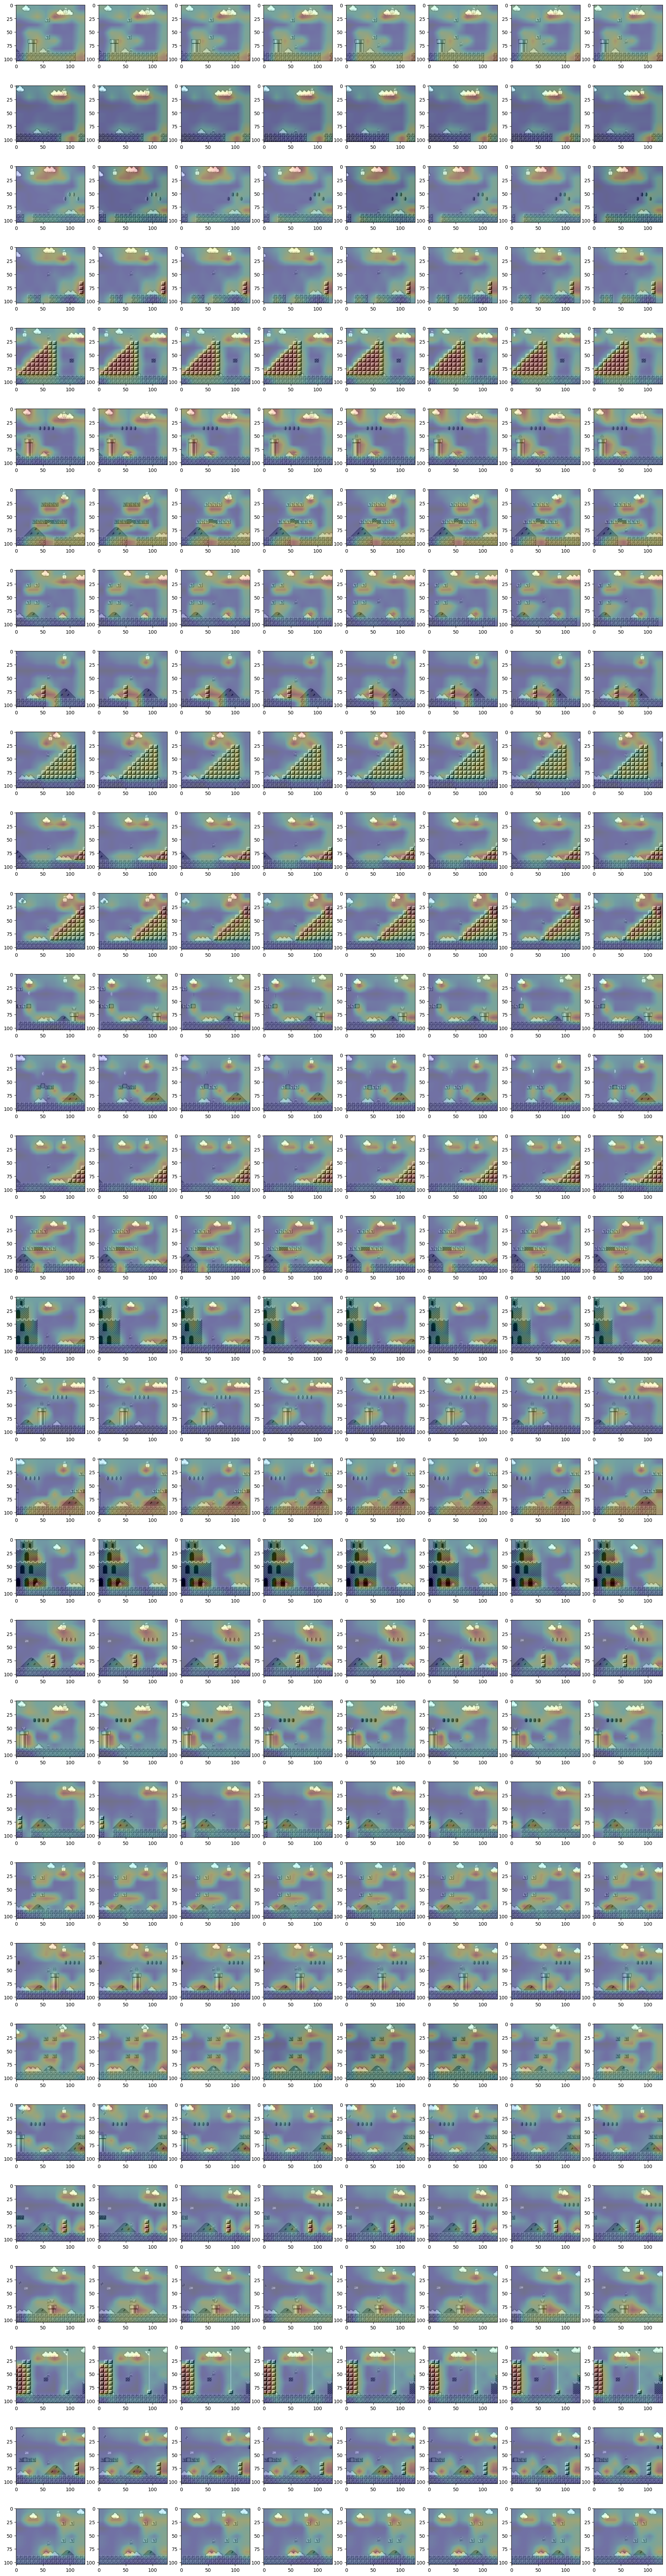

In [4]:
# sample a batch
obs, _, _ = next(iter(data_loader))

# go throught the model
with torch.no_grad():
    features_extractor.train(False)
    latent = features_extractor.conv1(obs.view(-1, 1, *obs.shape[-2:]) / 255.0)
    latent *= features_extractor.attention(latent)
    latent = latent.view(-1, 32, *latent.shape[-2:])
    latent = features_extractor.extractor(latent)
    attention_maps = features_extractor.attention2(latent).cpu().numpy()
    
# display the images with attention masks
_, plots = plt.subplots(obs.shape[0], obs.shape[1], figsize=(3 * obs.shape[1], 3 * obs.shape[0]))
for sequence, attention, axs, in zip(obs, attention_maps, plots):
    attention = cv2.resize(attention[0], (128, 104))
    for image, ax in zip(sequence, axs):
        ax.imshow(image.cpu(), cmap='gray')
        ax.imshow(attention, alpha=0.2, cmap="jet", interpolation='nearest')
plt.show()